#Original Model - Binary Dataset
# Deep Learning Medical Image Analysis
A simple convolutional neural network model trained using a simple pathology image dataset.

## Python Imports
This section will load the necessary python packages to the instance.

In [ ]:
from tensorflow import keras
keras.__version__

'2.12.0'

In [ ]:
# Built-in Imports
import random

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader (PneumoniaMNIST)
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance.

### Here we are using the PneumoniaMNIST dataset

In [ ]:
DATA_NAME = "PneumoniaMNIST"

In [ ]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2023-04-11 00:25:27--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22841 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0.002s  

2023-04-11 00:25:27 (11.1 MB/s) - ‘info.py’ saved [22841/22841]



In [ ]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

4170669/4170669 [==============================] - 1s 0us/step


In [ ]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path) #Pneumonia dataset

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# ImageDataGenerator requires 4 dimensions in the array. But here we have only 3 dimensions in the dataset as RGB channel is not present in the data.
# Therefore we add a new dimension using the following command. We do the same for the validation and test datasets.
train_x = train_x[..., np.newaxis]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]
val_x = val_x[..., np.newaxis]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]
test_x = test_x[..., np.newaxis]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [ ]:
#Pneumonia dataset
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)


#print(np.unique(train_y, return_counts=True))

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


1305: normal


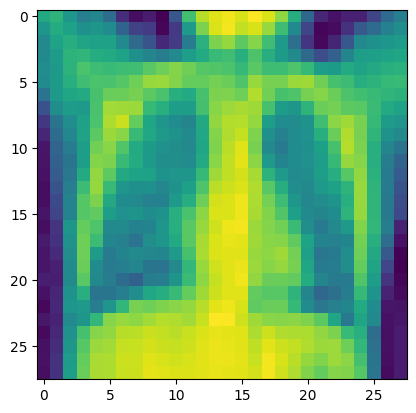

In [ ]:
#Pneumonia dataset
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [ ]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [ ]:
# Here we fit the ImageDataGenerator to the dataset
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

In [ ]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool1 = layers.MaxPool2D(pool_size=(2, 2))(conv1)

# Defines the second convolutional layer with max pooling.
conv2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool1)
pool2 = layers.MaxPool2D(pool_size=(2, 2))(conv2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0     

## Model Training
This is where we define the training options and then train the model.


In [ ]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [ ]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy", "AUC", "Precision", "Recall"])

In [ ]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
73/73 [==============================] - 14s 156ms/step - loss: 0.6465 - accuracy: 0.7421 - auc: 0.6294 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.6290 - val_accuracy: 0.7424 - val_auc: 0.6435 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 2/10
73/73 [==============================] - 5s 64ms/step - loss: 0.6182 - accuracy: 0.7421 - auc: 0.6545 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.6065 - val_accuracy: 0.7424 - val_auc: 0.6833 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 3/10
73/73 [==============================] - 3s 45ms/step - loss: 0.5947 - accuracy: 0.7421 - auc: 0.7100 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.5890 - val_accuracy: 0.7424 - val_auc: 0.7258 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 4/10
73/73 [==============================] - 3s 45ms/step - loss: 0.5730 - accuracy: 0.7421 - auc: 0.7744 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.5691 - val_accuracy: 0.7424 - val_auc: 0.7874 - val_precision: 0.7424

## Plot Learning Curves
This is where we visualise the training of the model.

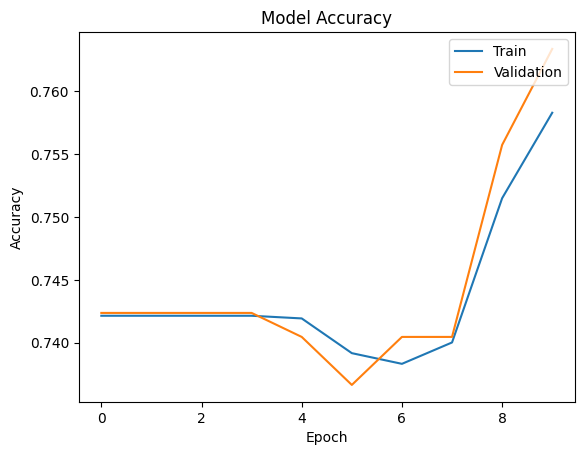

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

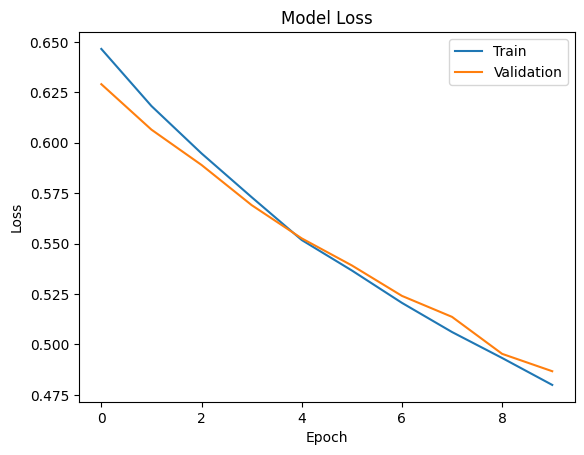

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

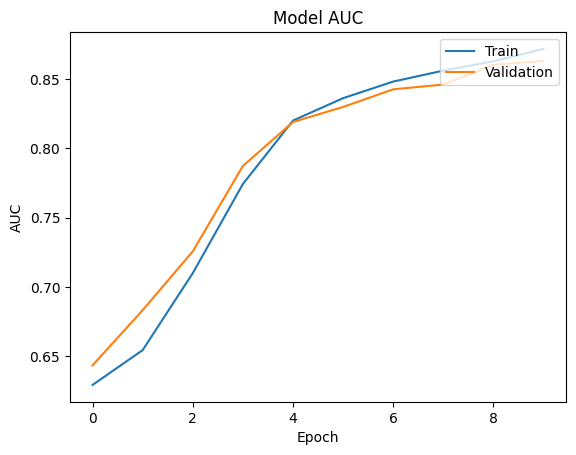

In [ ]:
# Plots the training and validation AUC over the number of epochs.
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

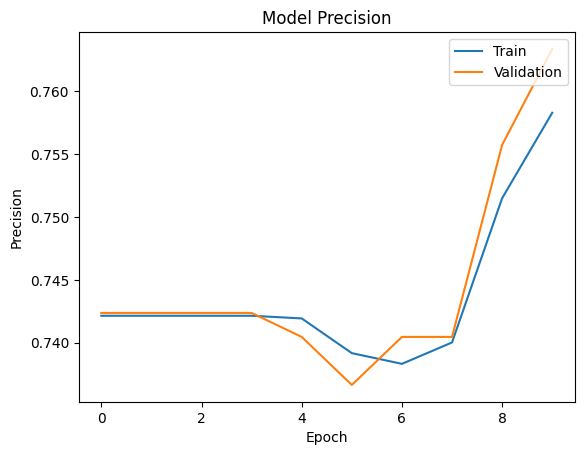

In [ ]:
# Plots the training and validation precision over the number of epochs.
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

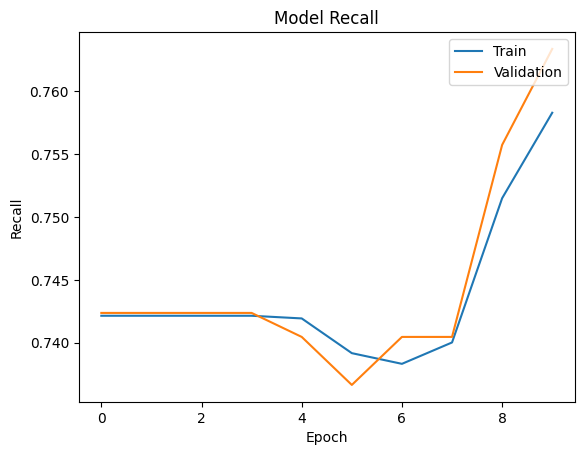

In [ ]:
# Plots the training and validation recall over the number of epochs.
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(data_generator.flow(test_x, to_categorical(test_y)))

20/20 [==============================] - 0s 9ms/step - loss: 0.6081 - accuracy: 0.6490 - auc: 0.7408 - precision: 0.6490 - recall: 0.6490


In [ ]:
print("PneumoniaMNIST\n" + "Loss - " + str(test_loss) + "\n" + "Accuracy - " + str(test_acc) + "\n" + "AUC - " + str(test_auc) + "\n" + "Precision - " + str(test_precision) + "\n" + "Recall - " + str(test_recall))

PneumoniaMNIST
Loss - 0.6081255674362183
Accuracy - 0.6490384340286255
AUC - 0.740753173828125
Precision - 0.6490384340286255
Recall - 0.6490384340286255
